Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 350kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.70MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Train Loss: 173.3677
Epoch 1, Test Loss: 133.7009
Epoch 2, Train Loss: 125.3120
Epoch 2, Test Loss: 119.0746
Epoch 3, Train Loss: 116.6812
Epoch 3, Test Loss: 114.3456
Epoch 4, Train Loss: 113.2523
Epoch 4, Test Loss: 111.9226
Epoch 5, Train Loss: 111.2983
Epoch 5, Test Loss: 110.5227
Epoch 6, Train Loss: 109.8869
Epoch 6, Test Loss: 109.1053
Epoch 7, Train Loss: 108.9143
Epoch 7, Test Loss: 108.7909
Epoch 8, Train Loss: 108.1288
Epoch 8, Test Loss: 107.9035
Epoch 9, Train Loss: 107.5714
Epoch 9, Test Loss: 107.3855
Epoch 10, Train Loss: 107.1442
Epoch 10, Test Loss: 107.0927


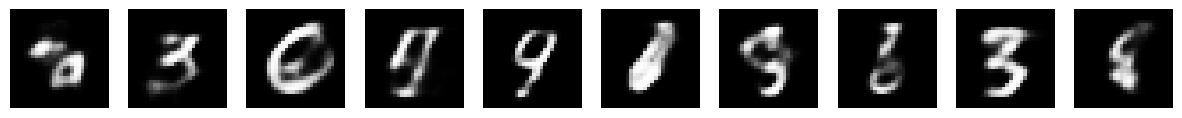

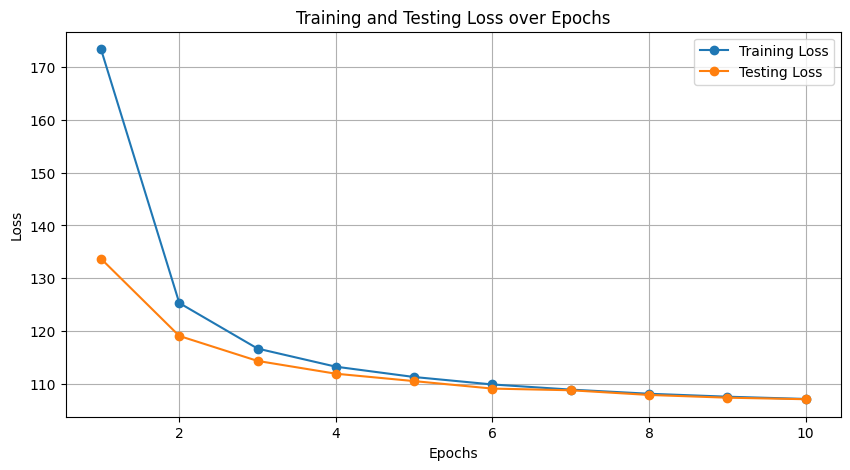

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_logvar = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encoder(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

transform = transforms.ToTensor()

full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}')

model.eval()
with torch.no_grad():
    z = torch.randn(64, 20)
    sample = model.decoder(z).cpu()
    sample = sample.view(64, 1, 28, 28)

def show_images(images):
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    for i in range(10):
        axes[i].imshow(images[i, 0], cmap='gray')
        axes[i].axis('off')
    plt.show()

show_images(sample[:10])

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()